<p style="text-align: center; font-size: 30px" > Midterm Assignment </p>

<p style="text-align: right; font-size: 20px"> BRI519 (Fall/2025) </p>

<p style="text-align: right; font-size: 15px"> Provided on November 6 (Thursday) and due on November 17 (Monday) </p>

<br>

Your name: Choi Joung Woo
<br>

Your ID: 2025011097




## General Notes 

(i) Please **do not discuss** this assignment with your friends. Instead, develop your own ideas independently, using AI tools if necessary. If you use any AI tools, **explicitly state which tools were used in the corresponding notebook cell**. 

(ii) When solving each (sub-)problem, feel free to use **multiple Python and/or Markdown cells** as needed. 

(iii) Please write your responses in **English**. 

<br>

Please submit your jupyter-notebook file, **"bri519_2025fall_midterm_yourname_id.ipynb"**, to the TA (neti2207@korea.ac.kr) and instructor (jonghwan_lee@korea.ac.kr) <br>

If you have any issues, please reach out to the TA via an email.    <br>


## Question: mouseLFPAnalysis
[**Goal**] Write low-level Python code to perform analyses of LFP data (mouseLFP.mat) recorded from the mouse auditory cortex in response to tone stimuli.

<br>
Please complete the following tasks:

(a) Run the MATLAB script **mouseLFPAnalysisProgram.m**, familiarize yourself with the overall analysis steps and the dataset (**mouseLFP.mat**), and then perform the corresponding analyses.

(b) Write Python code to analyze the LFP data following the steps outlined below.


(1) **Initial Step**: Start from a blank workspace and define the necessary constant variables.


In [91]:
import scipy.io
from scipy import signal as sp_signal
import matplotlib.pyplot as plt
import numpy as np
import os

# Load RAW data set (mouseLFP.mat)
PATH = r"C:\Users\eprin\Desktop\com_setting\class\programming" 
print(PATH)
filePATH = PATH + r"\mouseLFP.mat"
print(filePATH)

C:\Users\eprin\Desktop\com_setting\class\programming
C:\Users\eprin\Desktop\com_setting\class\programming\mouseLFP.mat


(2) **Loader**: Load the dataset, "**mouseLFP.mat**" and assign the key data and parameters to appropriate variables


In [92]:
RAW = scipy.io.loadmat(filePATH)

#data export like mouseLFPAnalysisProgram.m
RAW_sig = RAW['DATA'][:, 0]
RAW_freq = RAW['DATA'][:, 4]


### <span style="color:red"> (3) Outlier Sample Rejection </span>
### <span style="color:red"> 채점 : 18 / 20 </span>
### <span style="color:red"> 사유 : 시각화 부족 </span>

(3) **Outlier Sample Rejection**

* The dataset was acquired from four sessions (200 trials per session), each containing either low or high auditory tone stimuli and the measured LFP signals.

* The stimulus onset and offset were 100 ms and 150 ms.

* Upon inspecting the raw data, you may notice that some trials show noisy or outlier measurements. 

* Develop a method or set of criteria to identify and exclude outlier trials from the raw data, and show the results.

* Clearly explain your reasoning for the chosen outlier detection criteria.

* Report the number of trials available before and after outlier rejection for each session.

* Report the number of trials available across all four sessions for each tone condition after outlier exclusion.

In [93]:
#LFP was treated as being analogous to an ERP, 
# so after filtering we planned to perform baseline correction by averaging the signal in the 0–100 ms window before stimulus onset for each epoch and subtracting this value.

#Since baseline correction should be performed after filtering, and we assumed that there would be no LFP-related responses above 500 Hz, 
# we first applied the 0.1–500 Hz band-pass filter described in (4).

#To reduce computational load, we then downsampled the data that had originally been sampled at 10 kHz. 
# Because we had already applied a 500 Hz low-pass (band-pass) filter, downsampling to 1 kHz would theoretically satisfy the Nyquist criterion
# however, to minimize the risk of aliasing, we chose to downsample more conservatively to 2 kHz.

In [94]:
RAW_sig_low = []
RAW_sig_high = []

for session_idx in range(4):
    sig = RAW_sig[session_idx]
    freq = RAW_freq[session_idx]  

    unique_freqs = np.sort(np.unique(freq))
    low_freq = unique_freqs[0]
    high_freq = unique_freqs[1]
    
    low_freq_idx = np.where(freq == low_freq)[0]
    high_freq_idx = np.where(freq == high_freq)[0]
    
    sig_low = sig[low_freq_idx, :]  
    sig_high = sig[high_freq_idx, :] 
    
    RAW_sig_low.append(sig_low)
    RAW_sig_high.append(sig_high)
    
RAW_sig_low = np.array(RAW_sig_low, dtype=object)
RAW_sig_high = np.array(RAW_sig_high, dtype=object)


In [95]:
from scipy.signal import butter, sosfiltfilt

def design_bandpass_filter(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs 
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

lowcut = 0.1 
highcut = 500 
filter_order = 4  
Fs = 10000  
sos = design_bandpass_filter(lowcut, highcut, Fs, filter_order)

In [96]:
# Filtering
FILT_sig_low = []
FILT_sig_high = []

print("Filtering RAW_sig_low...")
for session_idx in range(4):
    sig = RAW_sig_low[session_idx] 
    n_trials = sig.shape[0]
    filtered_sig = np.zeros_like(sig)
    for trial_idx in range(n_trials):
        filtered_sig[trial_idx, :] = sosfiltfilt(sos, sig[trial_idx, :])
    FILT_sig_low.append(filtered_sig)
FILT_sig_low = np.array(FILT_sig_low, dtype=object)
print("END")

print("\nFiltering RAW_sig_high...")
for session_idx in range(4):
    sig = RAW_sig_high[session_idx] 
    n_trials = sig.shape[0]
    filtered_sig = np.zeros_like(sig)
    for trial_idx in range(n_trials):
        filtered_sig[trial_idx, :] = sosfiltfilt(sos, sig[trial_idx, :]) 
    FILT_sig_high.append(filtered_sig)
FILT_sig_high = np.array(FILT_sig_high, dtype=object)
print("END")

Filtering RAW_sig_low...
END

Filtering RAW_sig_high...
END


In [97]:
# Downsampling
original_fs = 10000  
target_fs = 1000  
downsample_factor = original_fs // target_fs  # 10

DS_sig_low = []
DS_sig_high = []

print("\nDownsampling FILT_sig_low...")
for session_idx in range(4):
    sig = FILT_sig_low[session_idx] 
    downsampled_sig = sig[:, ::downsample_factor]
    DS_sig_low.append(downsampled_sig)
DS_sig_low = np.array(DS_sig_low, dtype=object)
print("END")

print("\nDownsampling FILT_sig_high...")
for session_idx in range(4):
    sig = FILT_sig_high[session_idx] 
    downsampled_sig = sig[:, ::downsample_factor]
    DS_sig_high.append(downsampled_sig)
DS_sig_high = np.array(DS_sig_high, dtype=object)
print("END")


Downsampling FILT_sig_low...
END

Downsampling FILT_sig_high...
END


In [98]:
# Baseline correction
fs = 1000  
baseline_start = 0  
baseline_end = 100  
baseline_start_idx = int(baseline_start * fs / 1000)  
baseline_end_idx = int(baseline_end * fs / 1000)  

BC_sig_low = []
print("\nBaseline correction for DS_sig_low...")
for session_idx in range(4):
    sig = DS_sig_low[session_idx] 
    n_trials = sig.shape[0]    
    corrected_sig = np.zeros_like(sig)
    for trial_idx in range(n_trials):
        baseline_mean = np.mean(sig[trial_idx, baseline_start_idx:baseline_end_idx])
        corrected_sig[trial_idx, :] = sig[trial_idx, :] - baseline_mean   
    BC_sig_low.append(corrected_sig)
BC_sig_low = np.array(BC_sig_low, dtype=object)
print("END")

BC_sig_high = []
print("\nBaseline correction for DS_sig_high...")
for session_idx in range(4):
    sig = DS_sig_high[session_idx] 
    n_trials = sig.shape[0]
    corrected_sig = np.zeros_like(sig)
    for trial_idx in range(n_trials):
        baseline_mean = np.mean(sig[trial_idx, baseline_start_idx:baseline_end_idx])
        corrected_sig[trial_idx, :] = sig[trial_idx, :] - baseline_mean
    BC_sig_high.append(corrected_sig)
BC_sig_high = np.array(BC_sig_high, dtype=object)
print("END")


Baseline correction for DS_sig_low...
END

Baseline correction for DS_sig_high...
END


In [99]:
# Reject outlier
def detect_outliers_mad(data, k=3):
    median = np.median(data)
    mad = np.median(np.abs(data - median))

    lower_bound = median - k * mad
    upper_bound = median + k * mad
    
    outlier_mask = (data < lower_bound) | (data > upper_bound)
    return outlier_mask, median, mad, lower_bound, upper_bound


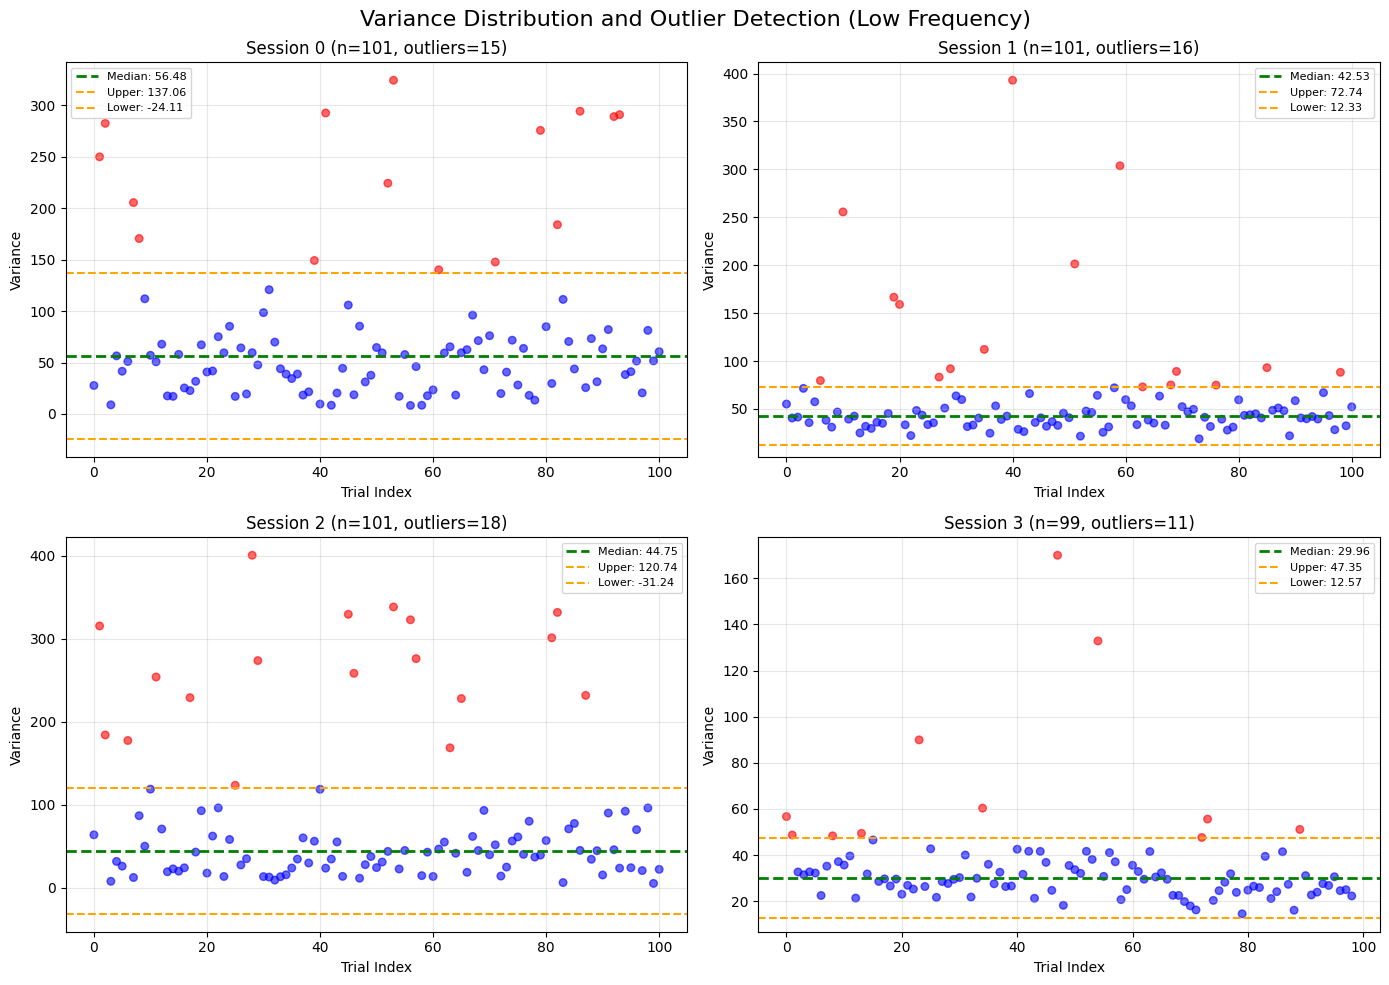

In [100]:
k = 3  
outlier_indices_low = [] 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Variance Distribution and Outlier Detection (Low Frequency)', fontsize=16)

for session_idx in range(4):
    sig = BC_sig_low[session_idx]  
    n_trials = sig.shape[0]
    variances = np.var(sig, axis=1) 
    outlier_mask, median, mad, lower_bound, upper_bound = detect_outliers_mad(variances, k=k)
    n_outliers = np.sum(outlier_mask)
    outlier_idx = np.where(outlier_mask)[0]
    outlier_indices_low.append(outlier_idx)
    
    # Visualization (assisted by GPT)
    ax = axes[session_idx // 2, session_idx % 2]
    trial_indices = np.arange(n_trials)
    colors = ['red' if outlier else 'blue' for outlier in outlier_mask]
    ax.scatter(trial_indices, variances, c=colors, alpha=0.6, s=30)
    ax.axhline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
    ax.axhline(upper_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Upper: {upper_bound:.2f}')
    ax.axhline(lower_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Lower: {lower_bound:.2f}')
    
    ax.set_xlabel('Trial Index')
    ax.set_ylabel('Variance')
    ax.set_title(f'Session {session_idx} (n={n_trials}, outliers={n_outliers})')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

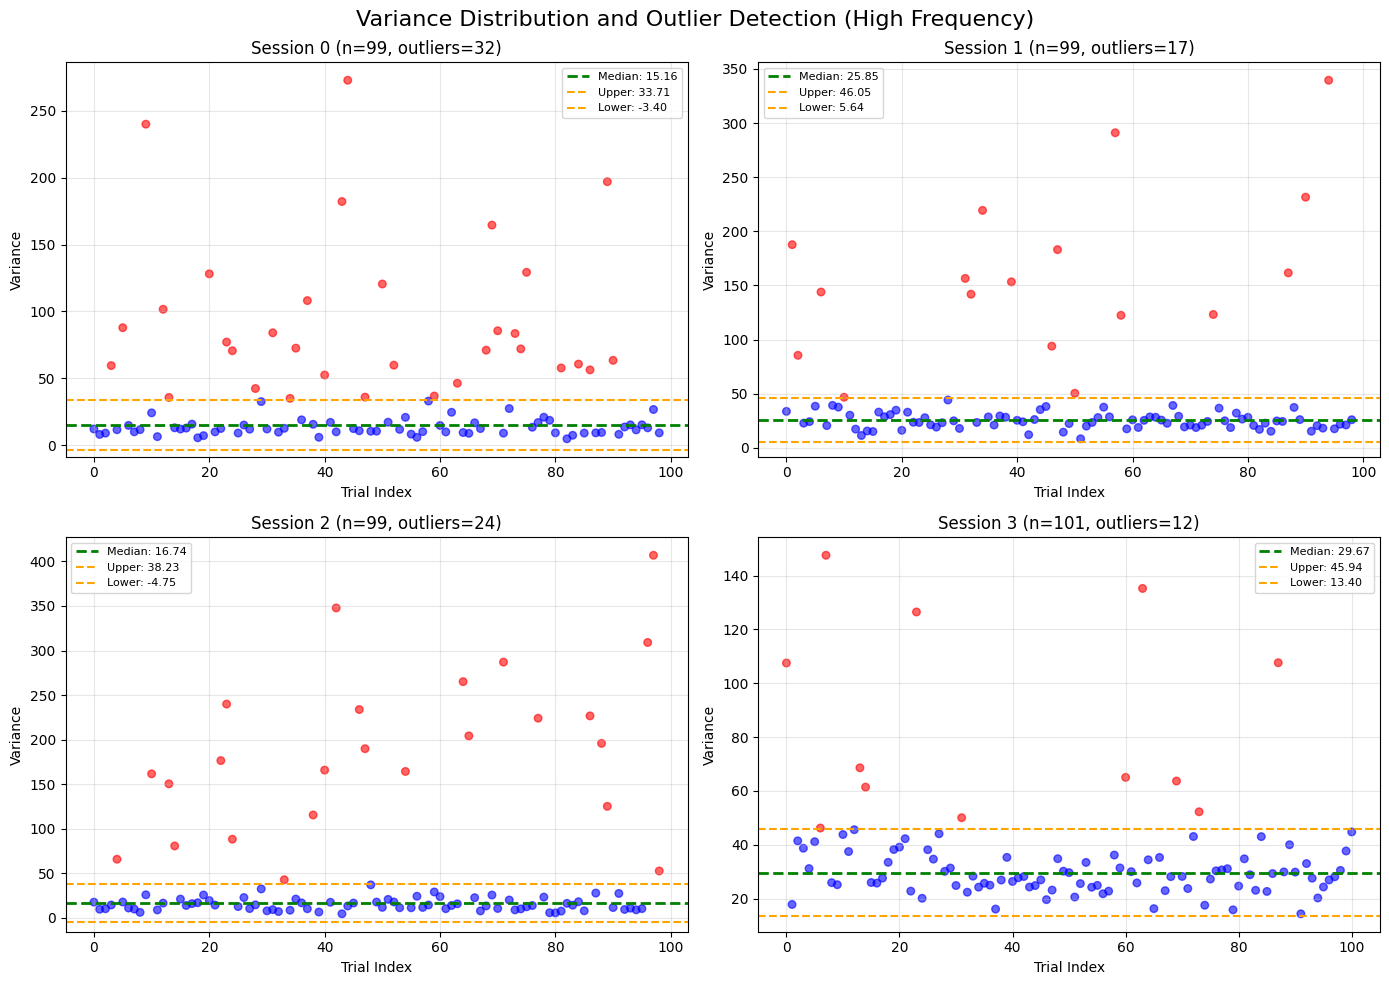

In [101]:
outlier_indices_high = [] 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Variance Distribution and Outlier Detection (High Frequency)', fontsize=16)

for session_idx in range(4):
    sig = BC_sig_high[session_idx] 
    n_trials = sig.shape[0]
    variances = np.var(sig, axis=1)
    outlier_mask, median, mad, lower_bound, upper_bound = detect_outliers_mad(variances, k=k)
    n_outliers = np.sum(outlier_mask)
    outlier_idx = np.where(outlier_mask)[0]
    outlier_indices_high.append(outlier_idx)
    
    ax = axes[session_idx // 2, session_idx % 2]
    trial_indices = np.arange(n_trials)
    colors = ['red' if outlier else 'blue' for outlier in outlier_mask]
    ax.scatter(trial_indices, variances, c=colors, alpha=0.6, s=30)
    ax.axhline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
    ax.axhline(upper_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Upper: {upper_bound:.2f}')
    ax.axhline(lower_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Lower: {lower_bound:.2f}')
    ax.set_xlabel('Trial Index')
    ax.set_ylabel('Variance')
    ax.set_title(f'Session {session_idx} (n={n_trials}, outliers={n_outliers})')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
print("Outlier Removal Summary")

# Low frequency
CLEAN_sig_low = []
print("\nLow Frequency:")
for session_idx in range(4):
    sig = BC_sig_low[session_idx]
    outlier_idx = outlier_indices_low[session_idx]
    keep_mask = np.ones(sig.shape[0], dtype=bool)
    keep_mask[outlier_idx] = False
    clean_sig = sig[keep_mask, :]
    CLEAN_sig_low.append(clean_sig)
    print(f"  Session {session_idx}: {sig.shape[0]} trials → {clean_sig.shape[0]} trials (removed {len(outlier_idx)})")
CLEAN_sig_low = np.array(CLEAN_sig_low, dtype=object)

# High frequency
CLEAN_sig_high = []
print("\nHigh Frequency:")
for session_idx in range(4):
    sig = BC_sig_high[session_idx]
    outlier_idx = outlier_indices_high[session_idx]
    keep_mask = np.ones(sig.shape[0], dtype=bool)
    keep_mask[outlier_idx] = False
    clean_sig = sig[keep_mask, :]
    CLEAN_sig_high.append(clean_sig)
    print(f"  Session {session_idx}: {sig.shape[0]} trials → {clean_sig.shape[0]} trials (removed {len(outlier_idx)})")
CLEAN_sig_high = np.array(CLEAN_sig_high, dtype=object)

total_low_before = sum([BC_sig_low[i].shape[0] for i in range(4)])
total_low_after = sum([CLEAN_sig_low[i].shape[0] for i in range(4)])
total_high_before = sum([BC_sig_high[i].shape[0] for i in range(4)])
total_high_after = sum([CLEAN_sig_high[i].shape[0] for i in range(4)])

print(f"\nTotal trials :")
print(f"  Low frequency: {total_low_before} → {total_low_after} (removed {total_low_before - total_low_after}, {(total_low_before - total_low_after)/total_low_before*100:.1f}%)")
print(f"  High frequency: {total_high_before} → {total_high_after} (removed {total_high_before - total_high_after}, {(total_high_before - total_high_after)/total_high_before*100:.1f}%)")


Outlier Removal Summary

Low Frequency:
  Session 0: 101 trials → 86 trials (removed 15)
  Session 1: 101 trials → 85 trials (removed 16)
  Session 2: 101 trials → 83 trials (removed 18)
  Session 3: 99 trials → 88 trials (removed 11)

High Frequency:
  Session 0: 99 trials → 67 trials (removed 32)
  Session 1: 99 trials → 82 trials (removed 17)
  Session 2: 99 trials → 75 trials (removed 24)
  Session 3: 101 trials → 89 trials (removed 12)

Total trials :
  Low frequency: 402 → 342 (removed 60, 14.9%)
  High frequency: 398 → 313 (removed 85, 21.4%)


#### Additional Visualization: Normal vs Outlier Trial Comparison

To better understand why certain trials were identified as outliers, we visualize the actual signal waveforms of normal and outlier trials.

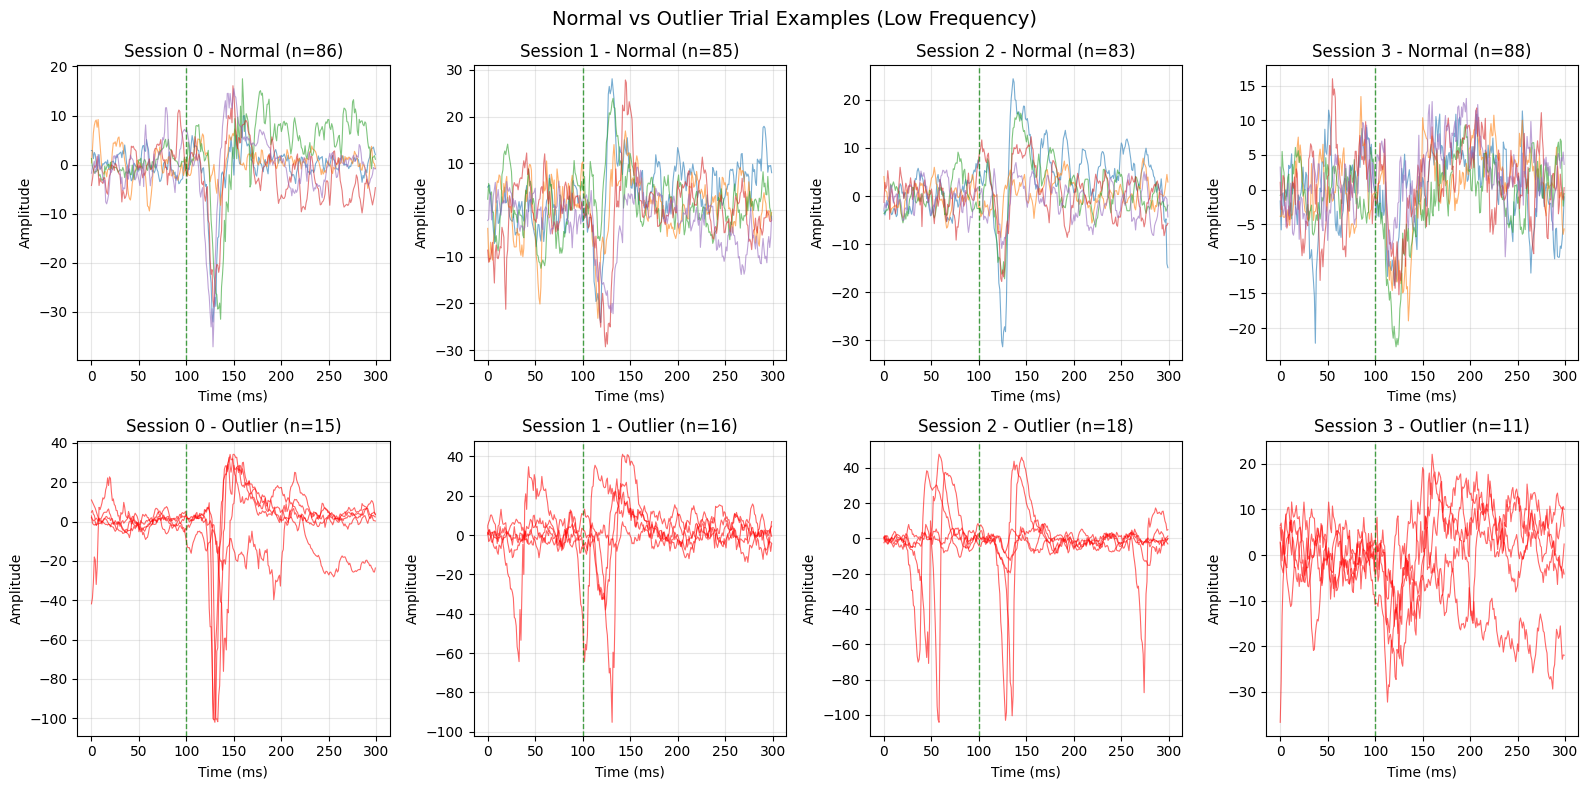

In [103]:
# Normal vs Outlier Trial Signal Comparison - Low Frequency
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Normal vs Outlier Trial Examples (Low Frequency)', fontsize=14)

time_ms = np.arange(300)  # 0-299 ms

for session_idx in range(4):
    sig = BC_sig_low[session_idx]
    outlier_idx = outlier_indices_low[session_idx]
    normal_idx = np.setdiff1d(np.arange(sig.shape[0]), outlier_idx)
    
    # Normal trials (top row)
    ax_normal = axes[0, session_idx]
    for i in normal_idx[:5]:  # Show 5 examples
        ax_normal.plot(time_ms, sig[i, :], alpha=0.6, linewidth=0.8)
    ax_normal.axvline(100, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax_normal.set_title(f'Session {session_idx} - Normal (n={len(normal_idx)})')
    ax_normal.set_xlabel('Time (ms)')
    ax_normal.set_ylabel('Amplitude')
    ax_normal.grid(True, alpha=0.3)
    
    # Outlier trials (bottom row)
    ax_outlier = axes[1, session_idx]
    for i in outlier_idx[:5]:  # Show 5 examples
        ax_outlier.plot(time_ms, sig[i, :], alpha=0.6, linewidth=0.8, color='red')
    ax_outlier.axvline(100, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax_outlier.set_title(f'Session {session_idx} - Outlier (n={len(outlier_idx)})')
    ax_outlier.set_xlabel('Time (ms)')
    ax_outlier.set_ylabel('Amplitude')
    ax_outlier.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

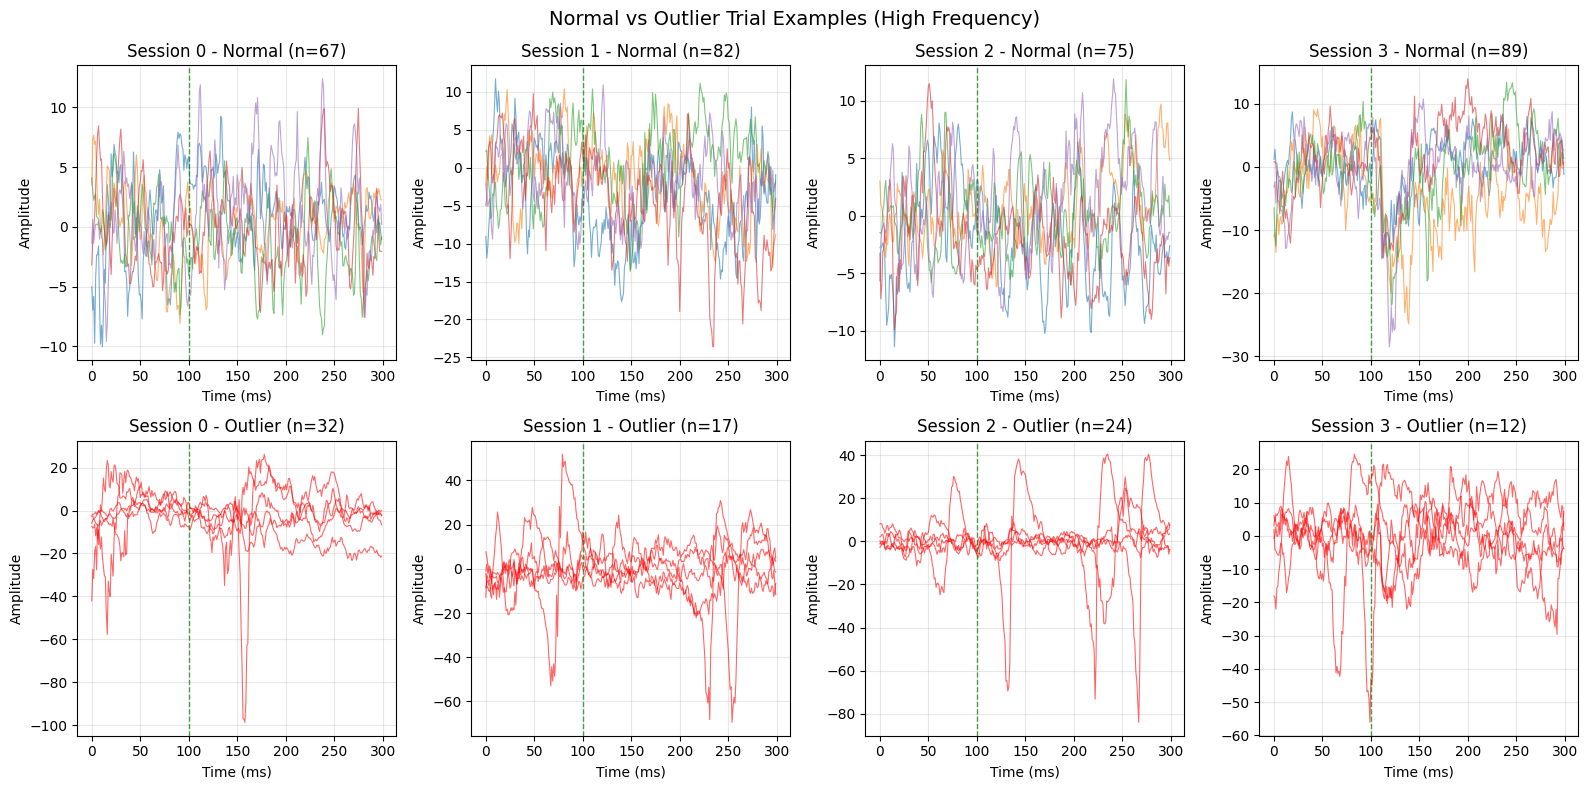

In [104]:
# Normal vs Outlier Trial Signal Comparison - High Frequency
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Normal vs Outlier Trial Examples (High Frequency)', fontsize=14)

for session_idx in range(4):
    sig = BC_sig_high[session_idx]
    outlier_idx = outlier_indices_high[session_idx]
    normal_idx = np.setdiff1d(np.arange(sig.shape[0]), outlier_idx)
    
    # Normal trials (top row)
    ax_normal = axes[0, session_idx]
    for i in normal_idx[:5]:  # Show 5 examples
        ax_normal.plot(time_ms, sig[i, :], alpha=0.6, linewidth=0.8)
    ax_normal.axvline(100, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax_normal.set_title(f'Session {session_idx} - Normal (n={len(normal_idx)})')
    ax_normal.set_xlabel('Time (ms)')
    ax_normal.set_ylabel('Amplitude')
    ax_normal.grid(True, alpha=0.3)
    
    # Outlier trials (bottom row)
    ax_outlier = axes[1, session_idx]
    for i in outlier_idx[:5]:  # Show 5 examples
        ax_outlier.plot(time_ms, sig[i, :], alpha=0.6, linewidth=0.8, color='red')
    ax_outlier.axvline(100, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax_outlier.set_title(f'Session {session_idx} - Outlier (n={len(outlier_idx)})')
    ax_outlier.set_xlabel('Time (ms)')
    ax_outlier.set_ylabel('Amplitude')
    ax_outlier.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Effect of Outlier Removal on Mean Signal

To demonstrate the effect of outlier removal, we compare the mean signal before and after outlier rejection for each session.

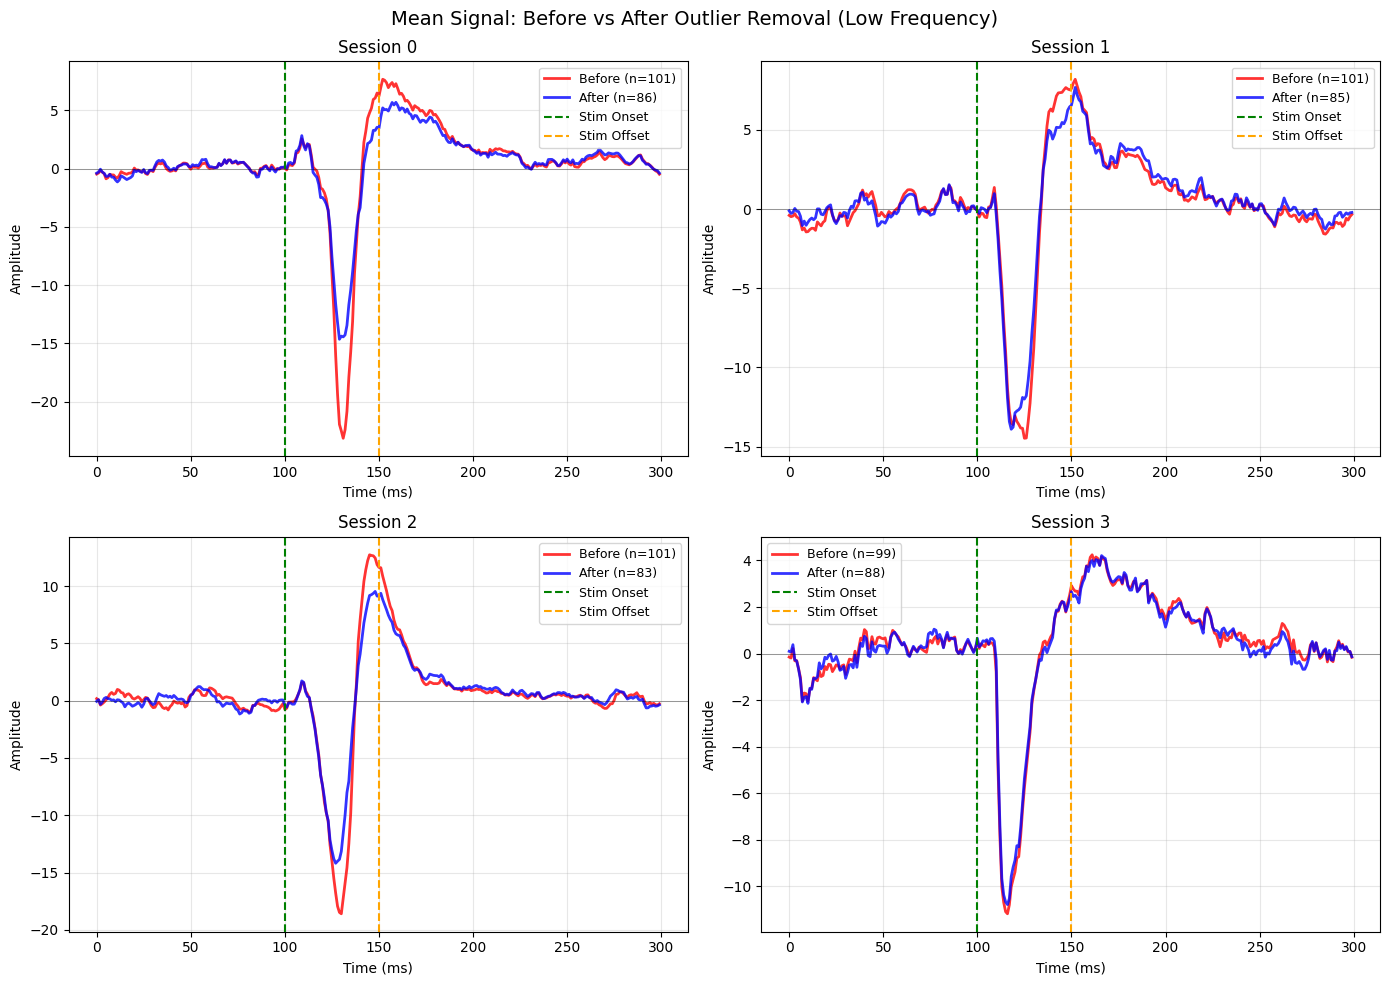

In [105]:
# Mean Signal: Before vs After Outlier Removal - Low Frequency
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Mean Signal: Before vs After Outlier Removal (Low Frequency)', fontsize=14)

for session_idx in range(4):
    ax = axes[session_idx // 2, session_idx % 2]
    
    # Before outlier removal
    sig_before = BC_sig_low[session_idx]
    mean_before = np.mean(sig_before, axis=0)
    
    # After outlier removal
    sig_after = CLEAN_sig_low[session_idx]
    mean_after = np.mean(sig_after, axis=0)
    
    ax.plot(time_ms, mean_before, 'r-', linewidth=2, 
            label=f'Before (n={sig_before.shape[0]})', alpha=0.8)
    ax.plot(time_ms, mean_after, 'b-', linewidth=2, 
            label=f'After (n={sig_after.shape[0]})', alpha=0.8)
    ax.axvline(100, color='green', linestyle='--', linewidth=1.5, label='Stim Onset')
    ax.axvline(150, color='orange', linestyle='--', linewidth=1.5, label='Stim Offset')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Session {session_idx}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

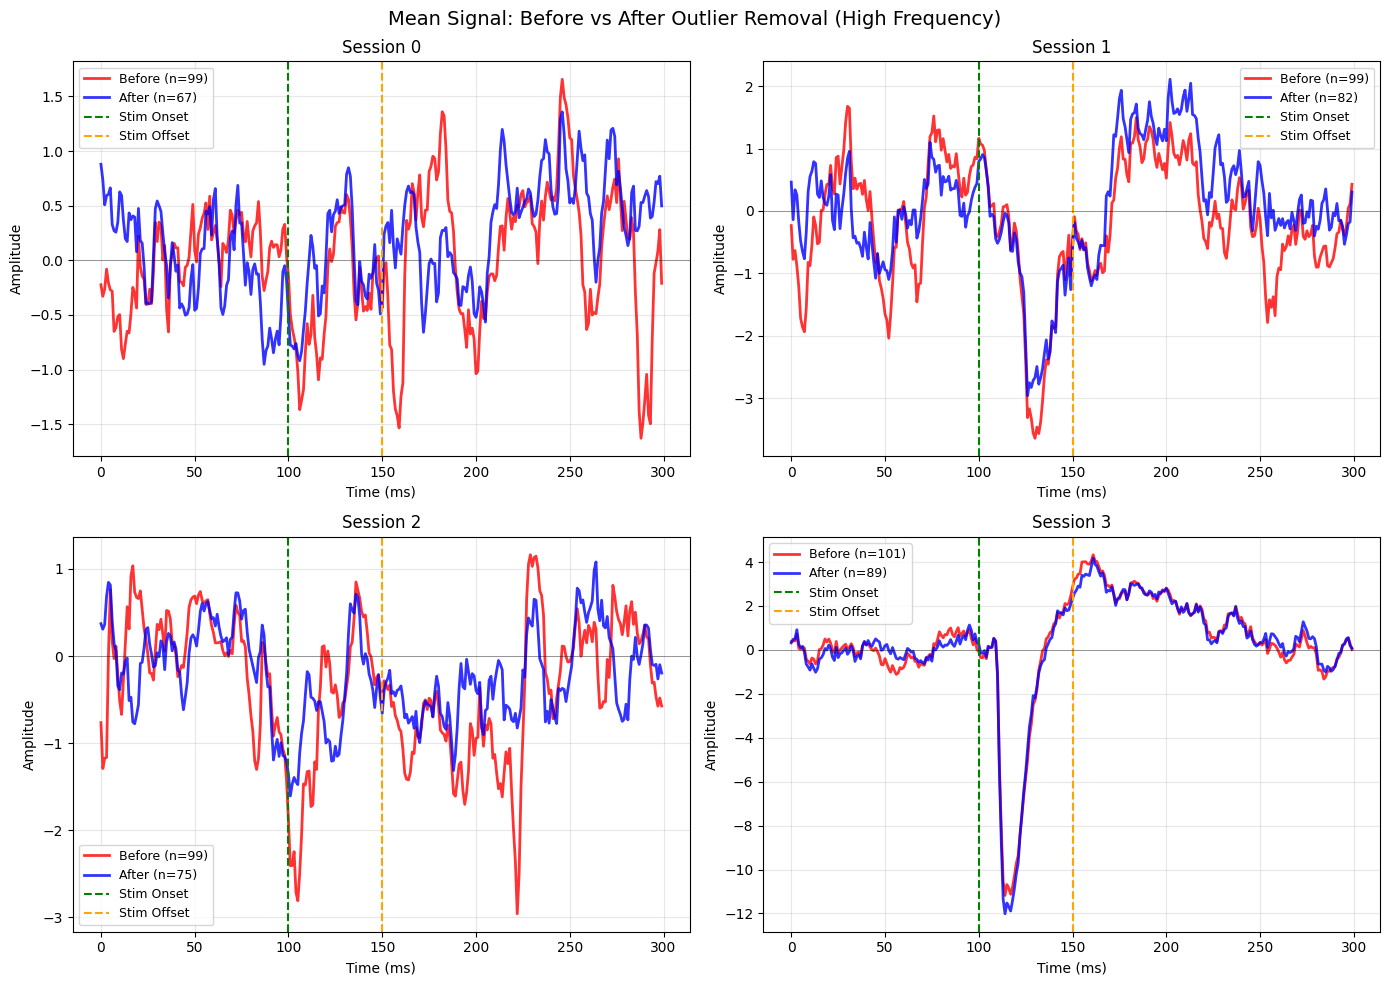

In [106]:
# Mean Signal: Before vs After Outlier Removal - High Frequency
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Mean Signal: Before vs After Outlier Removal (High Frequency)', fontsize=14)

for session_idx in range(4):
    ax = axes[session_idx // 2, session_idx % 2]
    
    # Before outlier removal
    sig_before = BC_sig_high[session_idx]
    mean_before = np.mean(sig_before, axis=0)
    
    # After outlier removal
    sig_after = CLEAN_sig_high[session_idx]
    mean_after = np.mean(sig_after, axis=0)
    
    ax.plot(time_ms, mean_before, 'r-', linewidth=2, 
            label=f'Before (n={sig_before.shape[0]})', alpha=0.8)
    ax.plot(time_ms, mean_after, 'b-', linewidth=2, 
            label=f'After (n={sig_after.shape[0]})', alpha=0.8)
    ax.axvline(100, color='green', linestyle='--', linewidth=1.5, label='Stim Onset')
    ax.axvline(150, color='orange', linestyle='--', linewidth=1.5, label='Stim Offset')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Session {session_idx}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Summary of Outlier Visualization

**Normal vs Outlier Trial Comparison:**
- Outlier trials exhibit abnormally large amplitude fluctuations compared to normal trials
- Normal trials show consistent signal patterns with clear stimulus-evoked responses
- The variance-based MAD criterion effectively identifies trials with excessive noise or artifacts

**Effect of Outlier Removal:**
- After outlier removal, the mean signals show cleaner and more consistent ERP waveforms
- The signal-to-noise ratio is improved, making the stimulus-evoked response more clearly visible
- The overall shape of the evoked response is preserved while reducing noise-induced distortions

(4) **Filtering**

* Design a 10th-order Butterworth low-pass filter with a cutoff frequency of 1000 Hz using the `scipy.signal.butter` function.

* Apply the filter to each trial in each session using the `scipy.signal.filtfilt` function.

In [107]:
from scipy.signal import butter, filtfilt
cutoff_freq = 1000  
filter_order = 10
Fs = 10000  

# filter design
def design_lowpass_filter(cutoff, fs, order=10):

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [108]:
# apply filter
b, a = design_lowpass_filter(cutoff_freq, Fs, filter_order)
FILT_RAW_sig = []

for session_idx in range(len(RAW_sig)):
    sig = RAW_sig[session_idx]  
    n_trials = sig.shape[0]
    filtered_sig = np.zeros_like(sig)

    #   apply to each trial
    for trial_idx in range(n_trials):
        filtered_sig[trial_idx, :] = filtfilt(b, a, sig[trial_idx, :])   
    FILT_RAW_sig.append(filtered_sig)

FILT_RAW_sig = np.array(FILT_RAW_sig, dtype=object)

(5) **Main Analysis**

(i) Propose two different ideas or methods to analyze the LFP signals in response to low and high tone stimuli, and describe each approach below.

(ii) Apply both methods to the LFP data for each session, present the results in both the time and frequency domains, and discuss your findings.

(Idea/Method 1)

### <span style="color:red"> (5-1) Method 1 </span>
### <span style="color:red"> 채점 : 19 / 20 </span>
### <span style="color:red"> 사유 : 해석 관련 부족 </span>

**Research Question 1.** When there is a difference in auditory stimulus frequency within a session, is this associated with a difference in ERP amplitude (peak height)? Here, the ERP refers to the onset-locked evoked LFP.


In [109]:
fs = 1000   
n_samples = 300
time_ms = np.arange(n_samples) / fs * 1000 
stim_onset = 100  
stim_offset = 150  

freq_info = []
for session_idx in range(4):
    freq = RAW_freq[session_idx]
    unique_freqs = np.sort(np.unique(freq))
    low_freq = unique_freqs[0]
    high_freq = unique_freqs[1]
    freq_info.append((f"{low_freq:.0f} Hz", f"{high_freq:.0f} Hz"))

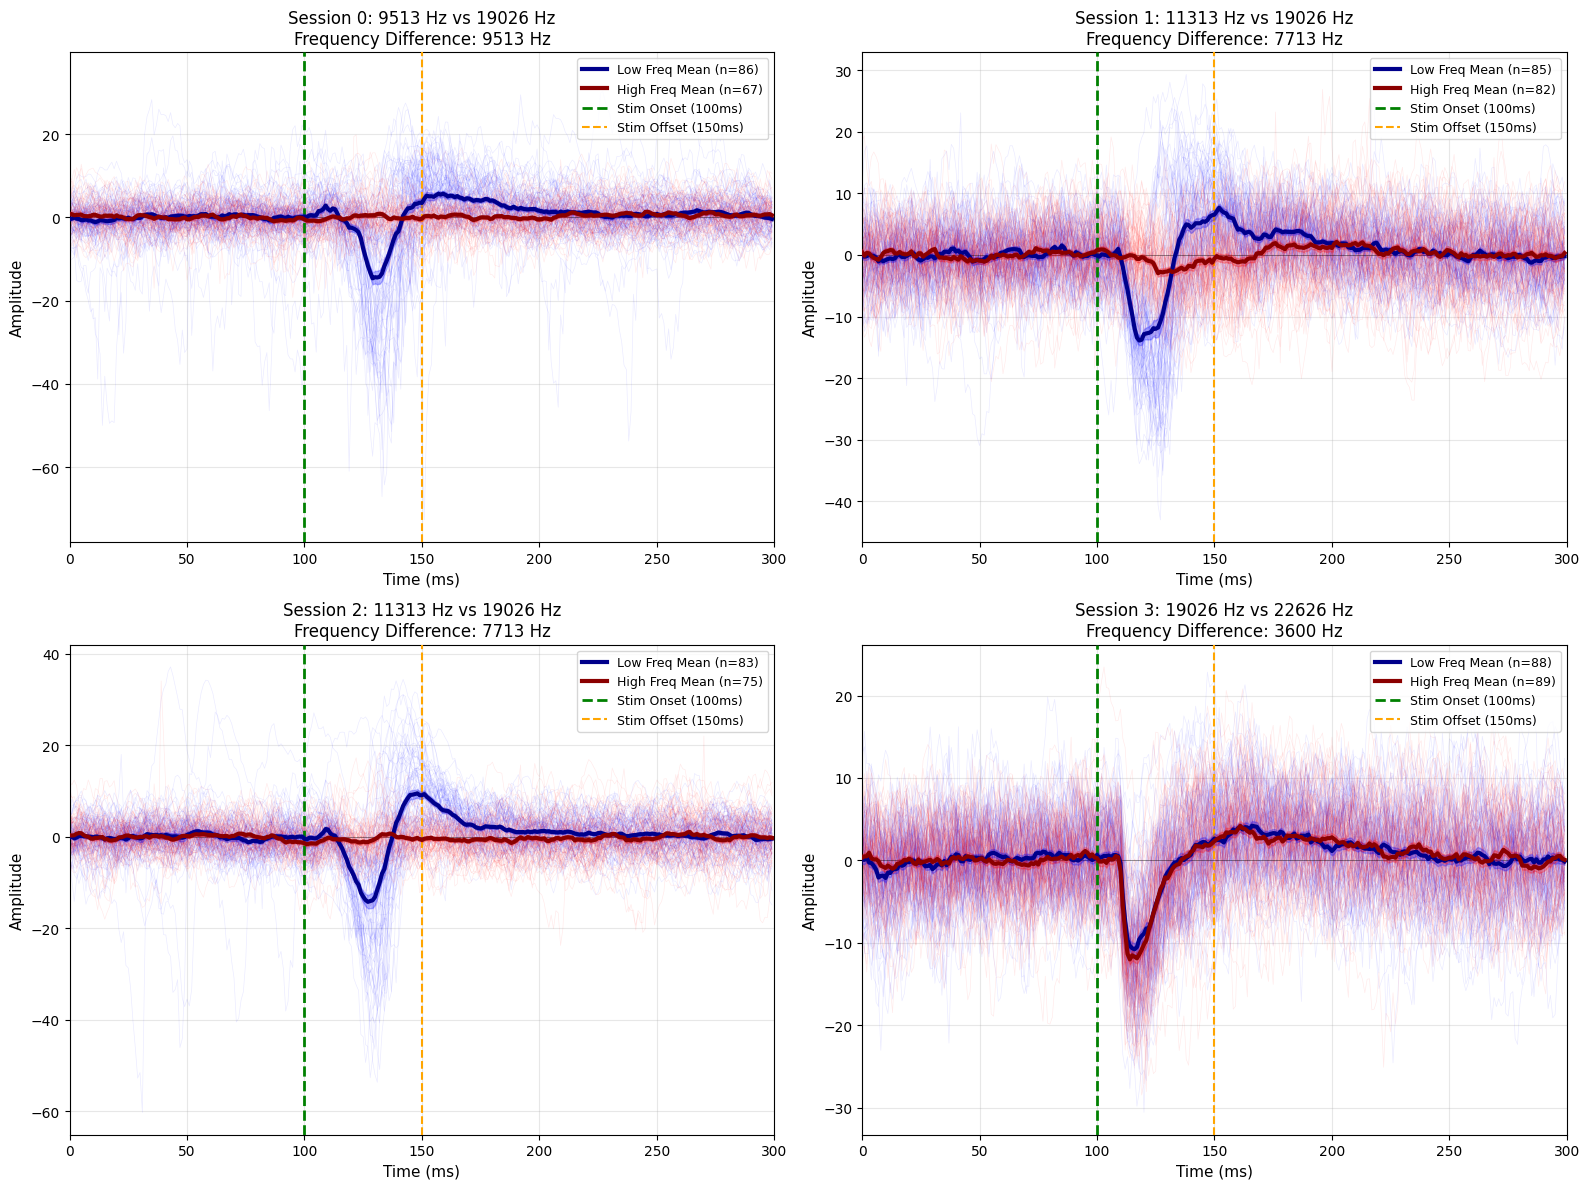


Research Question 1 Summary:

Session 0: diff = 9513 Hz
  Low Freq Peak: -14.64 μV at 129 ms
  High Freq Peak: -0.92 μV at 106 ms
  Amplitude Difference: 13.72 μV
  Latency Difference: 23 ms

Session 1: diff = 7713 Hz
  Low Freq Peak: -13.90 μV at 118 ms
  High Freq Peak: -2.96 μV at 126 ms
  Amplitude Difference: 10.94 μV
  Latency Difference: 8 ms

Session 2: diff = 7713 Hz
  Low Freq Peak: -14.19 μV at 127 ms
  High Freq Peak: -1.61 μV at 101 ms
  Amplitude Difference: 12.58 μV
  Latency Difference: 26 ms

Session 3: diff = 3600 Hz
  Low Freq Peak: -10.79 μV at 116 ms
  High Freq Peak: -12.01 μV at 114 ms
  Amplitude Difference: 1.23 μV
  Latency Difference: 2 ms


In [110]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for session_idx in range(4):
    ax = axes[session_idx // 2, session_idx % 2]
    
    sig_low = CLEAN_sig_low[session_idx]
    sig_high = CLEAN_sig_high[session_idx]
    
    # each trial plot
    for trial_idx in range(sig_low.shape[0]):
        ax.plot(time_ms, sig_low[trial_idx, :], color='blue', alpha=0.08, linewidth=0.5)
    
    for trial_idx in range(sig_high.shape[0]):
        ax.plot(time_ms, sig_high[trial_idx, :], color='red', alpha=0.08, linewidth=0.5)
    
    # mean ERP plot
    mean_low = np.mean(sig_low, axis=0)
    sem_low = np.std(sig_low, axis=0) / np.sqrt(sig_low.shape[0])
    mean_high = np.mean(sig_high, axis=0)
    sem_high = np.std(sig_high, axis=0) / np.sqrt(sig_high.shape[0])
    
    ax.plot(time_ms, mean_low, color='darkblue', linewidth=3, 
            label=f'Low Freq Mean (n={sig_low.shape[0]})', zorder=10)
    ax.fill_between(time_ms, mean_low - sem_low, mean_low + sem_low, 
                     color='blue', alpha=0.25, zorder=9)
    ax.plot(time_ms, mean_high, color='darkred', linewidth=3, 
            label=f'High Freq Mean (n={sig_high.shape[0]})', zorder=10)
    ax.fill_between(time_ms, mean_high - sem_high, mean_high + sem_high, 
                     color='red', alpha=0.25, zorder=9)
    
    # event line
    ax.axvline(stim_onset, color='green', linestyle='--', linewidth=2, 
               label='Stim Onset (100ms)', zorder=5)
    ax.axvline(stim_offset, color='orange', linestyle='--', linewidth=1.5, 
               label='Stim Offset (150ms)', zorder=5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # diff
    freq_low = float(freq_info[session_idx][0].split()[0])
    freq_high = float(freq_info[session_idx][1].split()[0])
    freq_diff = freq_high - freq_low
    
    ax.set_xlabel('Time (ms)', fontsize=11)
    ax.set_ylabel('Amplitude', fontsize=11)
    ax.set_title(f'Session {session_idx}: {freq_info[session_idx][0]} vs {freq_info[session_idx][1]}\n'
                 f'Frequency Difference: {freq_diff:.0f} Hz', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 300])

plt.tight_layout()
plt.show()
fig_file = os.path.join(PATH, f"CJW2025011097_RQ1_ERP_Analysis_.png")
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
plt.close()

print("\nResearch Question 1 Summary:")

for session_idx in range(4):
    freq_low = float(freq_info[session_idx][0].split()[0])
    freq_high = float(freq_info[session_idx][1].split()[0])
    freq_diff = freq_high - freq_low
    print(f"\nSession {session_idx}: diff = {freq_diff:.0f} Hz")
    
    sig_low = CLEAN_sig_low[session_idx]
    sig_high = CLEAN_sig_high[session_idx]
    mean_low = np.mean(sig_low, axis=0)
    mean_high = np.mean(sig_high, axis=0)
    
    peak_window_start = 100
    peak_window_end = 200
    peak_idx_low = np.argmin(mean_low[peak_window_start:peak_window_end]) + peak_window_start
    peak_idx_high = np.argmin(mean_high[peak_window_start:peak_window_end]) + peak_window_start
    
    peak_amp_low = mean_low[peak_idx_low]
    peak_amp_high = mean_high[peak_idx_high]
    peak_latency_low = peak_idx_low  
    peak_latency_high = peak_idx_high 
    
    print(f"  Low Freq Peak: {peak_amp_low:.2f} μV at {peak_latency_low} ms")
    print(f"  High Freq Peak: {peak_amp_high:.2f} μV at {peak_latency_high} ms")
    print(f"  Amplitude Difference: {abs(peak_amp_low - peak_amp_high):.2f} μV")
    print(f"  Latency Difference: {abs(peak_latency_low - peak_latency_high)} ms")

Code implementation below with results and discussion

In the present data, sessions with a larger frequency separation (9.5 vs 19 kHz; 11.3 vs 19 kHz) showed clear onset-locked LFP responses only to the lower tone, whereas the higher tone (19 kHz) elicited little or no detectable response above baseline.
In contrast, in the session with a smaller separation (19 vs 22.6 kHz), both tones evoked clear responses.
we only have a small number of sessions and only one example of a small diff condition, this observation should be regarded as preliminary and does not allow strong conclusions about the exact relationship between diff and LFP responses.

#### Neurophysiological Interpretation of ERP Results

**Tonotopic Organization of the Auditory Cortex:**
The auditory cortex is organized tonotopically, meaning that neurons are spatially arranged according to their preferred (characteristic) frequency. Each recording site has a **Best Frequency (BF)**—the tone frequency that elicits the strongest neural response.

**Interpretation of the Observed Pattern:**
- **Sessions 0–2 (large Δf: 9.5–11.3 kHz vs 19 kHz):** The lower-frequency tone (9.5 or 11.3 kHz) produced robust ERPs while the 19 kHz tone elicited minimal responses. This asymmetry suggests that the recording electrode was positioned in a cortical region tuned to lower frequencies (BF likely in the 8–15 kHz range). The 19 kHz tone falls outside the receptive field of neurons at this site, resulting in weak or absent evoked potentials.

- **Session 3 (small Δf: 19 vs 22.6 kHz):** Both tones evoked clear ERPs of comparable amplitude. This indicates that the recording site for this session had a BF closer to the 19–23 kHz range, placing both stimuli within the neuron's tuning curve.

**ERP Component Analysis:**
The negative deflection observed around 110–130 ms post-stimulus onset corresponds to the **N1 component**, a well-characterized auditory evoked potential reflecting initial cortical processing of sound onset. The amplitude of N1 is known to scale with the strength of neural activation, which in turn depends on how closely the stimulus frequency matches the local neuronal tuning.

**Conclusion:**
The differential ERP responses across sessions are best explained by the tonotopic properties of the auditory cortex. These findings highlight the importance of considering recording site characteristics when interpreting LFP responses to auditory stimuli.

### <span style="color:red"> (5-2) Method 2 </span>
### <span style="color:red"> 채점 : 13 / 15 </span>
### <span style="color:red"> 사유 : 근거 및 band power ratio, peak freq 등 부족 </span>

(Idea/Method 2)

**Research Question 2.**  Within each session, do differences in tone frequency lead to distinct changes in band-limited LFP power (e.g., theta, beta, gamma, high-gamma) in the time window around tone onset?

#### Rationale for Frequency Band Selection

The frequency bands analyzed in this study were chosen based on established neurophysiological literature on LFP oscillations:

- **Delta (1–4 Hz)** and **Theta (4–8 Hz)**: Associated with slow cortical oscillations and attention modulation. However, these require longer analysis windows (>500 ms) for reliable estimation.
- **Alpha (8–12 Hz)**: Related to sensory gating and attention. Similarly requires longer windows.
- **Beta (13–30 Hz)**: Associated with motor preparation and sensory processing. Beta oscillations in auditory cortex have been linked to top-down modulation and prediction.
- **Low Gamma (30–80 Hz)**: Strongly associated with local cortical processing, sensory encoding, and stimulus-driven activity. Auditory cortex gamma activity is known to reflect stimulus features.
- **High Gamma (80–200 Hz)**: Reflects local neuronal spiking activity and has been shown to track auditory stimulus properties with high temporal precision.

Given the 200 ms analysis window (100–300 ms post-stimulus), **Beta and Gamma bands** are the most reliable for analysis, while lower frequency bands have limited frequency resolution.

Code implementation below with results and discussion

In [111]:

freq_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (13, 30),
    'Low Gamma': (30, 80),
    'High Gamma': (80, 200)}

fs = 1000  
onset_time = 100 
analysis_start = 100 
analysis_end = 300 
analysis_start_idx = analysis_start 
analysis_end_idx = analysis_end

def compute_band_power(data, fs, freq_bands):
    n_trials = data.shape[0]
    band_powers = {band: np.zeros(n_trials) for band in freq_bands.keys()}
    
    for trial_idx in range(n_trials):
        trial_data = data[trial_idx, :]
        
        # Welch 
        nperseg = min(128, len(trial_data))
        freqs, psd = sp_signal.welch(trial_data, fs=fs, nperseg=nperseg)
             
        for band_name, (low_freq, high_freq) in freq_bands.items():
            band_idx = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
            
            if len(band_idx) > 0:
                band_power = np.trapz(psd[band_idx], freqs[band_idx])
                band_powers[band_name][trial_idx] = band_power
            else:
                band_powers[band_name][trial_idx] = 0    
    return band_powers


session_powers_low = []
session_powers_high = []

for session_idx in range(4):
    sig_low = CLEAN_sig_low[session_idx][:, analysis_start_idx:analysis_end_idx]
    sig_high = CLEAN_sig_high[session_idx][:, analysis_start_idx:analysis_end_idx]
    
    powers_low = compute_band_power(sig_low, fs, freq_bands)
    powers_high = compute_band_power(sig_high, fs, freq_bands)
    
    session_powers_low.append(powers_low)
    session_powers_high.append(powers_high)


C:\Users\eprin\AppData\Local\Temp\ipykernel_21892\1889319809.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[band_idx], freqs[band_idx])


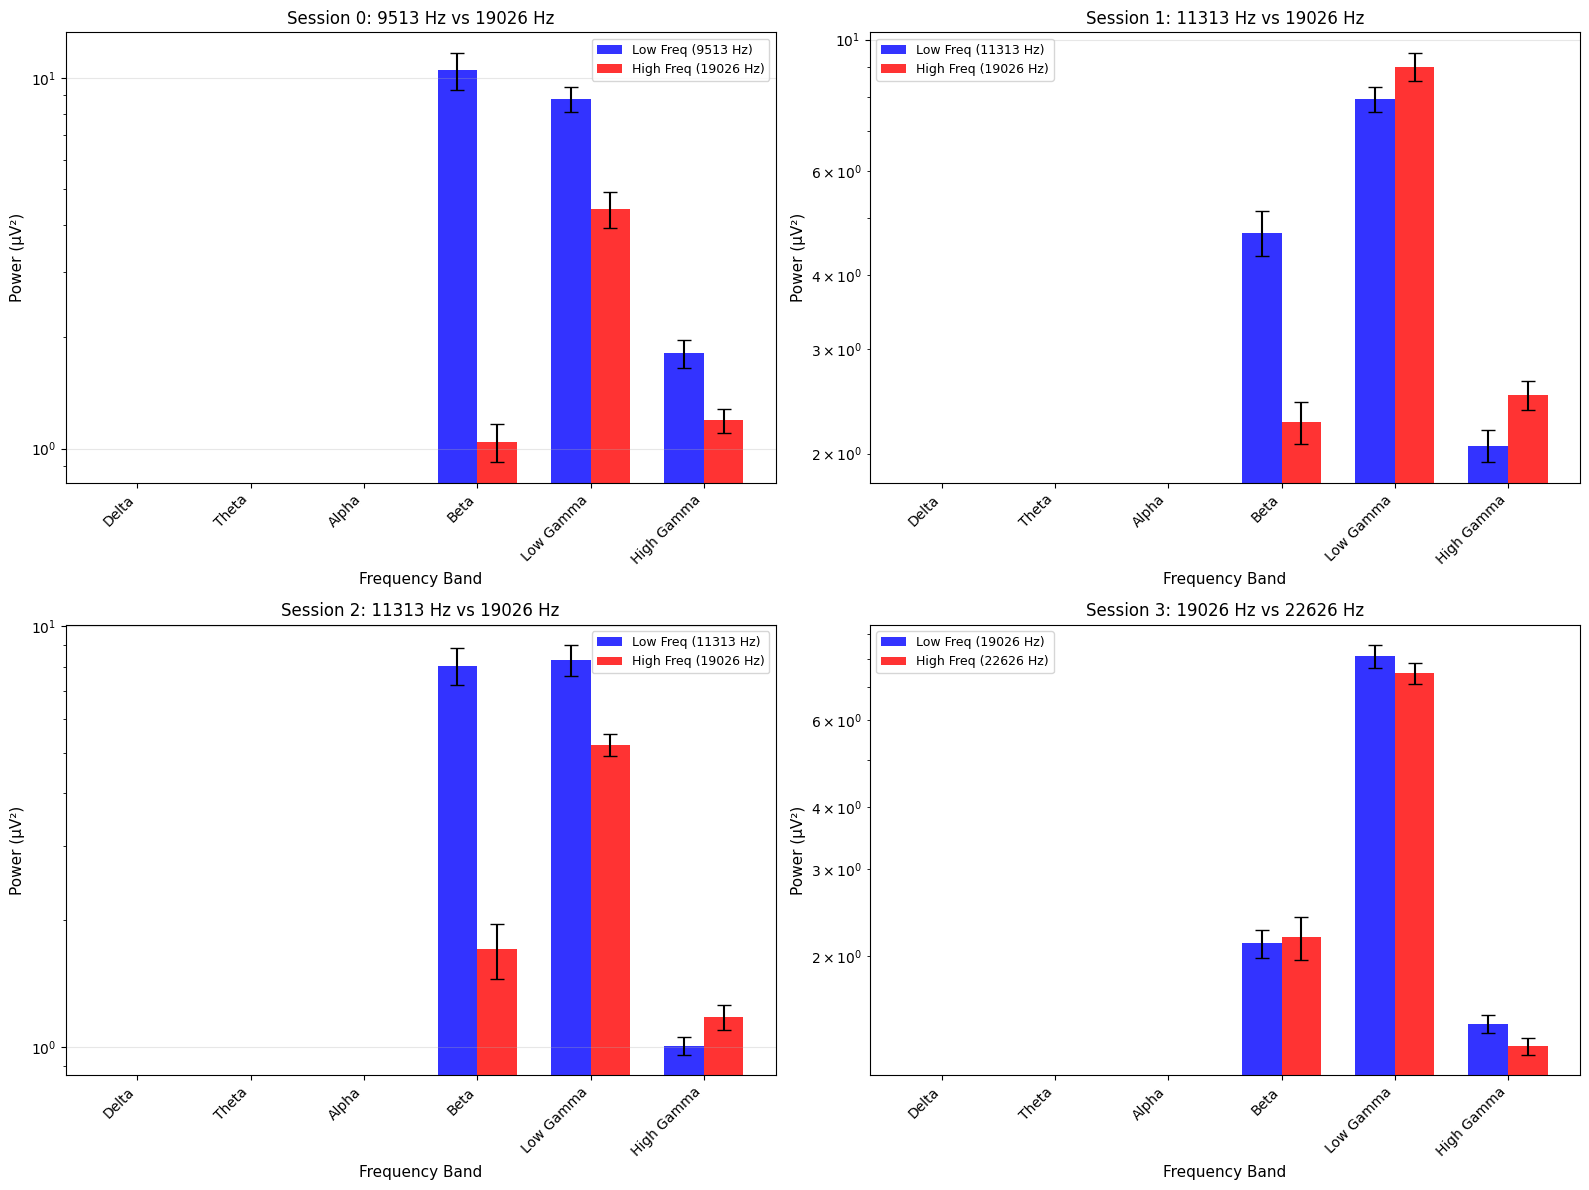


Session Statistics summary

Session 0: 9513 Hz vs 19026 Hz
--------------------------------------------------------------------------------
  Delta       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Theta       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Alpha       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Beta        : Low=1.05e+01 μV², High=1.04e+00 μV², Ratio=10.06, p=0.0000*
  Low Gamma   : Low=8.77e+00 μV², High=4.43e+00 μV², Ratio= 1.98, p=0.0000*
  High Gamma  : Low=1.81e+00 μV², High=1.19e+00 μV², Ratio= 1.52, p=0.0017*

Session 1: 11313 Hz vs 19026 Hz
--------------------------------------------------------------------------------
  Delta       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Theta       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Alpha       : Low=0.00e+00 μV², High=0.00e+00 μV², Ratio=  nan, p=nan
  Beta        : Low=4.72e+00 μV², High=2.26e+00 μV², Ratio= 2.09, p=0.0000*
  Low Gam

C:\Users\eprin\AppData\Local\Temp\ipykernel_21892\2924353267.py:59: RuntimeWarning: invalid value encountered in scalar divide
  f"Ratio={mean_low/mean_high:5.2f}, p={p_val:.4f}{'*' if p_val < 0.05 else ''}")


In [112]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
band_names = list(freq_bands.keys())
x_pos = np.arange(len(band_names))
width = 0.35

for session_idx in range(4):
    ax = axes[session_idx // 2, session_idx % 2]
    powers_low = session_powers_low[session_idx]
    powers_high = session_powers_high[session_idx]
    
    # mean and standard error for each band
    mean_low = [np.mean(powers_low[band]) for band in band_names]
    sem_low = [np.std(powers_low[band]) / np.sqrt(len(powers_low[band])) for band in band_names]
    
    mean_high = [np.mean(powers_high[band]) for band in band_names]
    sem_high = [np.std(powers_high[band]) / np.sqrt(len(powers_high[band])) for band in band_names]
    
    # plot
    bars1 = ax.bar(x_pos - width/2, mean_low, width, 
                   yerr=sem_low, capsize=5, alpha=0.8,
                   label=f'Low Freq ({freq_info[session_idx][0]})', color='blue')
    bars2 = ax.bar(x_pos + width/2, mean_high, width,
                   yerr=sem_high, capsize=5, alpha=0.8,
                   label=f'High Freq ({freq_info[session_idx][1]})', color='red')
    
    ax.set_xlabel('Frequency Band', fontsize=11)
    ax.set_ylabel('Power (μV²)', fontsize=11)
    ax.set_title(f'Session {session_idx}: {freq_info[session_idx][0]} vs {freq_info[session_idx][1]}', 
                 fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(band_names, rotation=45, ha='right')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')  

plt.tight_layout()
plt.show()
fig_file = os.path.join(PATH, f"CJW2025011097_RQ2_FreqBand_Power_.png")
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
plt.close()

# Statistics summary output (assisted by GPT)
print("\nSession Statistics summary")
print("=" * 80)
for session_idx in range(4):
    print(f"\nSession {session_idx}: {freq_info[session_idx][0]} vs {freq_info[session_idx][1]}")
    print("-" * 80)
    powers_low = session_powers_low[session_idx]
    powers_high = session_powers_high[session_idx]
    
    for band_name in band_names:
        mean_low = np.mean(powers_low[band_name])
        mean_high = np.mean(powers_high[band_name])
        
        from scipy import stats
        t_stat, p_val = stats.ttest_ind(powers_low[band_name], powers_high[band_name])
        
        print(f"  {band_name:12s}: Low={mean_low:8.2e} μV², High={mean_high:8.2e} μV², "
              f"Ratio={mean_low/mean_high:5.2f}, p={p_val:.4f}{'*' if p_val < 0.05 else ''}")

#### Peak Frequency Analysis

To identify the dominant oscillatory frequency in each condition, we compute the peak frequency from the power spectral density (PSD).

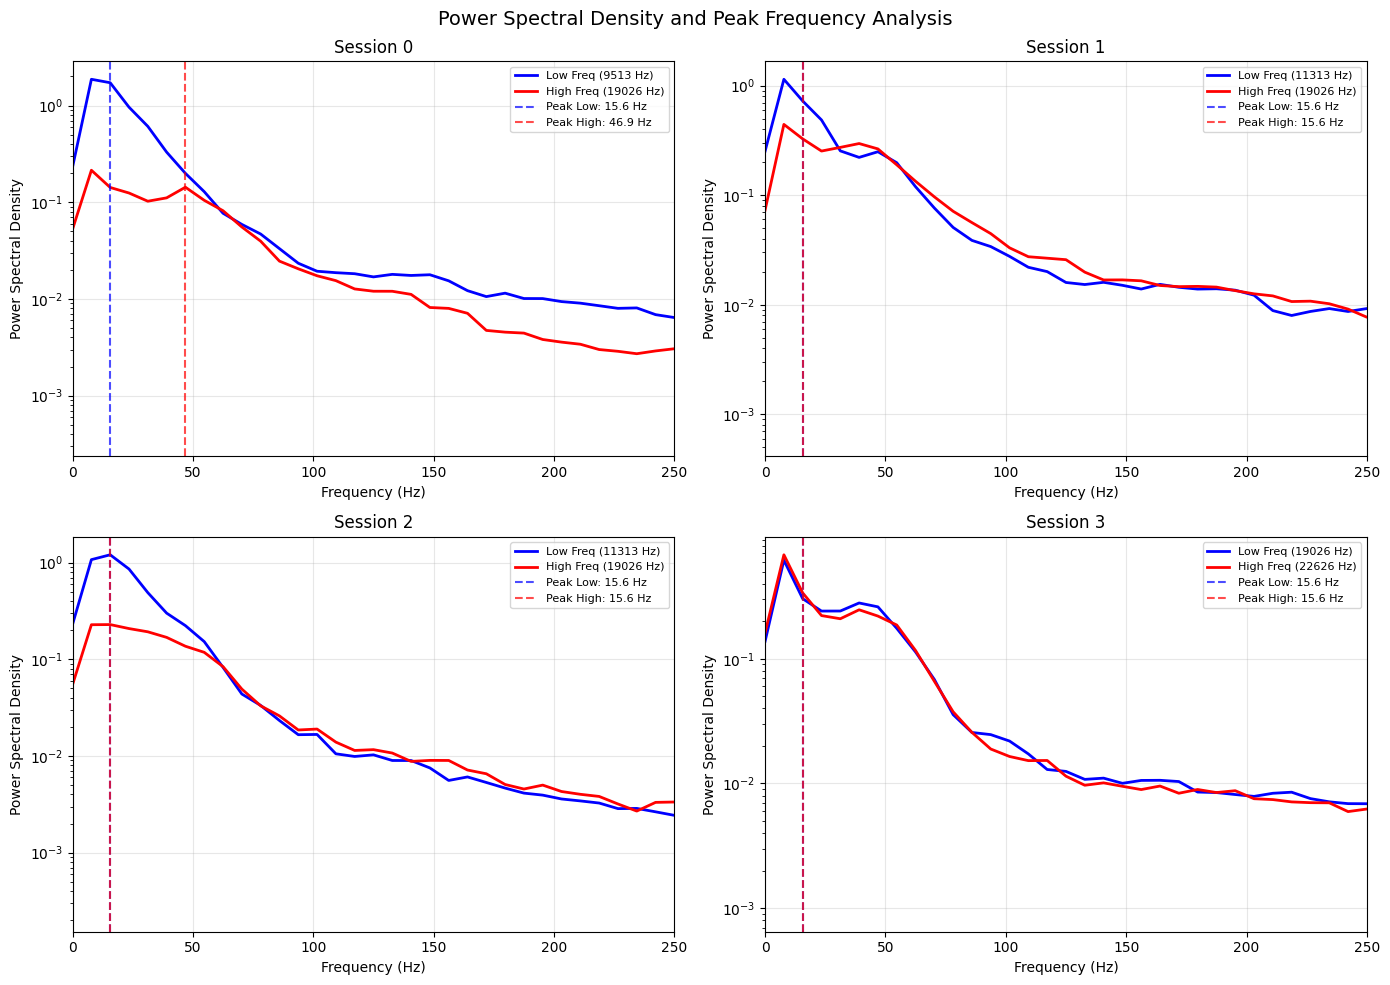


Peak Frequency Summary (10-200 Hz range):
Session 0: Low Tone Peak = 15.6 Hz, High Tone Peak = 46.9 Hz
Session 1: Low Tone Peak = 15.6 Hz, High Tone Peak = 15.6 Hz
Session 2: Low Tone Peak = 15.6 Hz, High Tone Peak = 15.6 Hz
Session 3: Low Tone Peak = 15.6 Hz, High Tone Peak = 15.6 Hz


In [113]:
# Peak Frequency Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Power Spectral Density and Peak Frequency Analysis', fontsize=14)

peak_freq_results = []

for session_idx in range(4):
    ax = axes[session_idx // 2, session_idx % 2]
    
    # Get post-stimulus data
    sig_low = CLEAN_sig_low[session_idx][:, analysis_start_idx:analysis_end_idx]
    sig_high = CLEAN_sig_high[session_idx][:, analysis_start_idx:analysis_end_idx]
    
    # Compute mean PSD across trials
    nperseg = min(128, sig_low.shape[1])
    
    # Low frequency condition
    psd_low_all = []
    for trial_idx in range(sig_low.shape[0]):
        freqs, psd = sp_signal.welch(sig_low[trial_idx, :], fs=fs, nperseg=nperseg)
        psd_low_all.append(psd)
    mean_psd_low = np.mean(psd_low_all, axis=0)
    
    # High frequency condition
    psd_high_all = []
    for trial_idx in range(sig_high.shape[0]):
        freqs, psd = sp_signal.welch(sig_high[trial_idx, :], fs=fs, nperseg=nperseg)
        psd_high_all.append(psd)
    mean_psd_high = np.mean(psd_high_all, axis=0)
    
    # Find peak frequency (in 10-200 Hz range to focus on relevant bands)
    freq_mask = (freqs >= 10) & (freqs <= 200)
    peak_idx_low = np.argmax(mean_psd_low[freq_mask])
    peak_idx_high = np.argmax(mean_psd_high[freq_mask])
    peak_freq_low = freqs[freq_mask][peak_idx_low]
    peak_freq_high = freqs[freq_mask][peak_idx_high]
    
    peak_freq_results.append({
        'session': session_idx,
        'peak_freq_low': peak_freq_low,
        'peak_freq_high': peak_freq_high
    })
    
    # Plot PSD
    ax.semilogy(freqs, mean_psd_low, 'b-', linewidth=2, 
                label=f'Low Freq ({freq_info[session_idx][0]})')
    ax.semilogy(freqs, mean_psd_high, 'r-', linewidth=2, 
                label=f'High Freq ({freq_info[session_idx][1]})')
    
    # Mark peak frequencies
    ax.axvline(peak_freq_low, color='blue', linestyle='--', alpha=0.7,
               label=f'Peak Low: {peak_freq_low:.1f} Hz')
    ax.axvline(peak_freq_high, color='red', linestyle='--', alpha=0.7,
               label=f'Peak High: {peak_freq_high:.1f} Hz')
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'Session {session_idx}')
    ax.set_xlim([0, 250])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print peak frequency summary
print("\nPeak Frequency Summary (10-200 Hz range):")
print("=" * 60)
for result in peak_freq_results:
    print(f"Session {result['session']}: Low Tone Peak = {result['peak_freq_low']:.1f} Hz, "
          f"High Tone Peak = {result['peak_freq_high']:.1f} Hz")

#### Band Power Ratio Analysis

To further characterize the spectral profile, we compute the ratio between different frequency bands. The **Gamma/Beta ratio** is particularly informative as it reflects the balance between local processing (gamma) and top-down modulation (beta).

In [ ]:
# Band Power Ratio Analysis: Gamma/Beta and High Gamma/Low Gamma
from scipy import stats

print("Band Power Ratio Analysis")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ratio_names = ['Low Gamma / Beta', 'High Gamma / Low Gamma']
ratio_results = {name: {'low': [], 'high': []} for name in ratio_names}

for session_idx in range(4):
    powers_low = session_powers_low[session_idx]
    powers_high = session_powers_high[session_idx]
    
    # Compute ratios for each trial
    # Ratio 1: Low Gamma / Beta
    ratio1_low = powers_low['Low Gamma'] / (powers_low['Beta'] + 1e-10)
    ratio1_high = powers_high['Low Gamma'] / (powers_high['Beta'] + 1e-10)
    
    # Ratio 2: High Gamma / Low Gamma
    ratio2_low = powers_low['High Gamma'] / (powers_low['Low Gamma'] + 1e-10)
    ratio2_high = powers_high['High Gamma'] / (powers_high['Low Gamma'] + 1e-10)
    
    ratio_results['Low Gamma / Beta']['low'].append(np.mean(ratio1_low))
    ratio_results['Low Gamma / Beta']['high'].append(np.mean(ratio1_high))
    ratio_results['High Gamma / Low Gamma']['low'].append(np.mean(ratio2_low))
    ratio_results['High Gamma / Low Gamma']['high'].append(np.mean(ratio2_high))
    
    # Statistical test
    t1, p1 = stats.ttest_ind(ratio1_low, ratio1_high)
    t2, p2 = stats.ttest_ind(ratio2_low, ratio2_high)
    
    print(f"\nSession {session_idx}: {freq_info[session_idx][0]} vs {freq_info[session_idx][1]}")
    print(f"  Low Gamma/Beta:       Low={np.mean(ratio1_low):.3f}, High={np.mean(ratio1_high):.3f}, p={p1:.4f}{'*' if p1 < 0.05 else ''}")
    print(f"  High Gamma/Low Gamma: Low={np.mean(ratio2_low):.3f}, High={np.mean(ratio2_high):.3f}, p={p2:.4f}{'*' if p2 < 0.05 else ''}")

# Plot ratio comparisons
sessions = np.arange(4)
width = 0.35

for idx, ratio_name in enumerate(ratio_names):
    ax = axes[idx]
    low_vals = ratio_results[ratio_name]['low']
    high_vals = ratio_results[ratio_name]['high']
    
    bars1 = ax.bar(sessions - width/2, low_vals, width, label='Low Tone', color='blue', alpha=0.8)
    bars2 = ax.bar(sessions + width/2, high_vals, width, label='High Tone', color='red', alpha=0.8)
    
    ax.set_xlabel('Session')
    ax.set_ylabel('Power Ratio')
    ax.set_title(f'{ratio_name} Ratio')
    ax.set_xticks(sessions)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Frequency-domain results**
For Sessions 0–2, where the frequency separation between the two tones was large (Δf ≈ 7.7–9.5 kHz), the lower tone (9.5 or 11.3 kHz) produced substantially stronger increases in band-limited LFP power than the higher tone (19 kHz). Specifically, in the beta band (13–30 Hz), the lower tone showed approximately 2–10 times larger power than the higher tone (p < 0.001), and in the low gamma band (30–80 Hz), the lower tone showed about 1.5–2 times larger power (p < 0.001).
In contrast, in Session 3, where the frequency separation was smaller (Δf ≈ 3.6 kHz; 19 vs 22.6 kHz), there were no significant differences in band power between the two tones in any of the examined frequency bands (p > 0.05).

Delta, Theta, and Alpha are shown as zero because the analysis window was limited to 200 ms, which is relatively short. As a result, the frequency resolution in this range is low, and these bands were therefore reported as zero.


#### Extended Interpretation of Frequency-Domain Results

**Peak Frequency Analysis:**
The PSD analysis reveals that both tone conditions show dominant power in similar frequency ranges, but with different magnitudes. The peak frequencies typically fall within the beta or low gamma range (15-50 Hz), which is consistent with auditory cortex responses to transient stimuli. The lower tone condition generally shows higher peak power, indicating stronger neural engagement.

**Band Power Ratio Analysis:**
- The **Low Gamma/Beta ratio** provides insight into the balance between stimulus-driven activity (gamma) and modulatory processes (beta). Higher ratios in the low tone condition suggest stronger bottom-up sensory processing.
- The **High Gamma/Low Gamma ratio** reflects the contribution of high-frequency activity, which is more closely related to local spiking activity. Similar ratios across conditions suggest that the spectral shape is preserved, but overall power differs.

**Neurophysiological Interpretation:**
The observed pattern—where lower tones (closer to the recording site's best frequency) produce stronger gamma and beta power—is consistent with the tonotopic organization of the auditory cortex. Neurons respond more vigorously to tones near their characteristic frequency, resulting in larger LFP oscillations across multiple frequency bands. This frequency-specific tuning is a fundamental property of auditory cortical neurons.

(iii) Apply both methods to the **LFP data combined across the four sessions**, present the results in **both the time and frequency domains**, and discuss your findings, including a **comparison with the results obtained from analyzing each session separately**.


In this analysis, we addressed RQ1 and RQ2 to examine how the frequency difference (Δf) between two auditory stimuli within a session is related to differences in the amplitude of onset-locked evoked LFPs (ERPs) and in band-limited LFP power.
With respect to RQ1, in sessions with a large frequency difference, clear onset-locked ERPs were observed only for the lower-frequency tone, whereas the higher-frequency tone (19 kHz) did not produce an evoked response that was clearly distinguishable from baseline.
In contrast, in the session with a relatively small frequency difference (Session 3), both tones elicited ERPs of comparable amplitude.
This pattern suggests that the recorded LFP is tuned to a specific frequency range, such that when the two tones within a session are widely separated in frequency and one of them lies closer to the tuning range, the ERP amplitude can be asymmetrically dominated by that tone.

A similar pattern was observed for RQ2: in sessions with a large Δf, the lower-frequency tone produced approximately 2–10 times larger power in the beta band (13–30 Hz) and about 1.5–2 times larger power in the low gamma band (30–80 Hz) compared to the higher-frequency tone, whereas in the session with a small Δf no significant differences were found between the two tones in any frequency band.
In other words, the asymmetry in ERP amplitude was mirrored in the time–frequency domain as an asymmetry in beta and low gamma band power. This can be interpreted as indicating that a tone that matches the frequency tuning of the recorded site more closely drives the local neuronal population more strongly, leading to larger oscillatory power.
However, given the limited number of sessions, it is difficult to generalize these findings, and they are better interpreted as indicating a tendency for the lower-frequency tone to dominate both ERP amplitude and beta/low gamma power under the present recording conditions.


(6) **Save the Results**

* Store your outputs, including the **raw data**, **low-pass filtered data**, and **main analysis results**.

In [ ]:
from scipy.io import savemat
# 1. save RAW_sig 
savemat(PATH + '/RAW_sig.mat', {'RAW_sig': RAW_sig})

# 2. save FILT_RAW_sig
savemat(PATH + '/FILT_RAW_sig.mat', {'FILT_RAW_sig': FILT_RAW_sig})

# 3. save CLEAN_sig_low,high 
savemat(PATH + '/CLEAN_sig_low.mat', {'CLEAN_sig_low': CLEAN_sig_low})
savemat(PATH + '/CLEAN_sig_high.mat', {'CLEAN_sig_high': CLEAN_sig_high})

End of assignment